# BG2 model with arky-pallidal connections

## 2016-09-07

This adds a arky-pallidal connections rather like those in Alex B's paper.

In [2]:
# Spike Threshold parameters
snr_spike_thresh = -15
stn_spike_thresh = -15
gpe_spike_thresh = 0
d1_spike_thresh = 0
d2_spike_thresh = 0

import sys
import os

def run_bg1_model (expt=0):
    sys.path.append("../analysis")
    modeldir = '/home/seb/izhibg/GPR_Izhikevich/bg2';
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+'; popd"';
    os.system(spinemlcmd);
    
# Compare spiking rate in channels
def channel_spiking (population_name, spike_thresh, start_ms, end_ms, start_channel, end_channel):

    # Make sure we have access to the load_sc_data and firing_rate functions
    import sys
    sys.path.append("../analysis")
    import load_sc_data as lsd
    import firing_rate as fr
    # Load data from SpineML_2_BRAHMS
    filepath = '/home/seb/src/SpineML_2_BRAHMS/temp/log/'+population_name+'_v_log.bin';
    V, count, t, nn, dt = lsd.load_sc_data(filepath)

    rates = []
    ratetot = 0
    numanalysed = 0
    
    if end_channel >= nn:
        print "end_channel =",end_channel,">= nn =",nn
    
    for i in range (start_channel,end_channel):
        rate, isiRate = fr.firing_rate2(V[i],(end_ms-start_ms),dt,spike_thresh,start_ms)
        rates.append(rate)
        ratetot = ratetot + rate;
        numanalysed = numanalysed + 1
    
    return float(ratetot)/numanalysed

## Here's the steady state behaviour with background input

In [4]:
expt = 1 # This is the "Steady state with background" expt
print 'Running bg2 model steady state experiment',expt
run_bg1_model (expt)
print 'Done.'

print '\n\'Steady state (with background input)\' results\n------------------'
r = channel_spiking('D1_MSN', d1_spike_thresh, 300, 800, 0, 19)
print 'D1 mean rate [60]: ', r,'spikes/s'
r = channel_spiking('D2_MSN', d2_spike_thresh, 300, 800, 0, 19)
print 'D2 mean rate [60]: ', r,'spikes/s'
r = channel_spiking('STN', stn_spike_thresh, 300, 800, 0, 19)
print 'STN mean rate [?]: ', r,'spikes/s'
r = channel_spiking('GPe', gpe_spike_thresh, 300, 800, 0, 19)
print 'GPe mean rate [?]: ', r,'spikes/s'
r = channel_spiking('GPi', snr_spike_thresh, 300, 800, 0, 19)
print 'SNr mean rate [25]: ', r,'spikes/s'

Running bg2 model steady state experiment 1
Done.

'Steady state (with background input)' results
------------------
D1 mean rate [60]:  44.5263157895 spikes/s
D2 mean rate [60]:  32.7368421053 spikes/s
STN mean rate [?]:  83.7894736842 spikes/s
GPe mean rate [?]:  259.789473684 spikes/s
SNr mean rate [25]:  28.9473684211 spikes/s


## Here's visualisation of the impulse response 

In [4]:
# Visualisation of mean firing rates from bg1 simulation, with and without sigmoid.
import numpy as np

# Graph the data. Sub-called by vis_data
def graph_data (bin_edges1, fr_sigI, logfile):
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,8))

    bincenters = 0.5*(bin_edges1[1:]+bin_edges1[:-1])
    
    plt.plot (bincenters, fr_sigI[0,:], '-', color='r', label='Ch0', linewidth=3)
    plt.plot (bin_edges1[0:-1],fr_sigI[1,:]+500, '-',  color='b', label='Ch1', linewidth=3)
    #plt.plot (bin_edges1[0:-1],fr_sigI[2,:], '--',  color='g', marker='o', label='Ch2', linewidth=3)

    plt.legend(loc='best',fontsize=14)

    plt.xlabel('t (ms)',fontsize=24);
    
    from matplotlib import rc
    plt.ylabel('mean neuronal firing rate (s$^{-1}$)',fontsize=24);
    plt.tick_params(axis='x', labelsize=24, pad=10)
    plt.tick_params(axis='y', labelsize=24, pad=10)
    
    plt.title(logfile)

    graphdir = '/home/seb/izhibg/GPR_Izhikevich/labbook/'

    filename = logfile.replace(' ','_')
    plt.savefig('{0}{1}.svg'.format(graphdir, filename))
    
    plt.show()

# Read & precompute the data. Sub-called by vis_data and compute_decision
def read_data (logdir1, logfile):
    logpath = logdir1 + logfile
    # sl_sigI is two columns, times and spike index
    sl_sigI = np.genfromtxt (logpath, delimiter=',')
    
    return sl_sigI

# Histogram the data for each neuron (expt should have run 100 times)
def compute_data_indiv (sl_sigI, numbins, numrepeatruns):

    ch1idx_sigI  = sl_sigI[:,1] == 12
    ch2idx_sigI  = sl_sigI[:,1] == 22
    ch3idx_sigI  = sl_sigI[:,1] == 45
    
    ch1fr, bin_edges1 = np.histogram (sl_sigI[ch1idx_sigI,0], numbins)
    ch2fr, bin_edges2 = np.histogram (sl_sigI[ch2idx_sigI,0], numbins)
    ch3fr, bin_edges3 = np.histogram (sl_sigI[ch3idx_sigI,0], numbins)
    fr_sigI = np.vstack((ch1fr,ch2fr,ch3fr))
    allfr_sigI, bin_edgesall = np.histogram (sl_sigI[:,0], numbins)

    # There are 20 neurons per channel in this model, 60 total
    neuronsPerChan = 1
    num_channels_used = 3 # We only take data from first 3 channels!
    neuronsPerInvestigation = neuronsPerChan * num_channels_used

    simlength_ms = 2000    
    
    # Scale the firing rates
    bintime = simlength_ms / numbins;
    fr_sigI  = (fr_sigI) * 1000 / (bintime * neuronsPerChan * numrepeatruns)
    allfr_sigI = (allfr_sigI * 1000) / (bintime * neuronsPerInvestigation * numrepeatruns)

    return bin_edges1, fr_sigI

# Visualise the given logfile (the log of a single population) for the two
# simulation outputs in logdir1 and logdir2. Assumptions about what kind of
# data is in logdir1 and logdir2 are made.
def vis_data (logdir1, logfile):
    sl_sigI = read_data (logdir1, logfile)
    bin_edges1, fr_sigI = compute_data_indiv (sl_sigI)
    graph_data (bin_edges1, fr_sigI, logfile)

def vis_much_data (sl_sigI, numbins, numrepeatruns, graphname):    
    bin_edges1, fr_sigI = compute_data_indiv (sl_sigI, numbins, numrepeatruns)
    graph_data (bin_edges1, fr_sigI, graphname)


## Visualise the impulse response

Response of BG1TC model to impulse input.


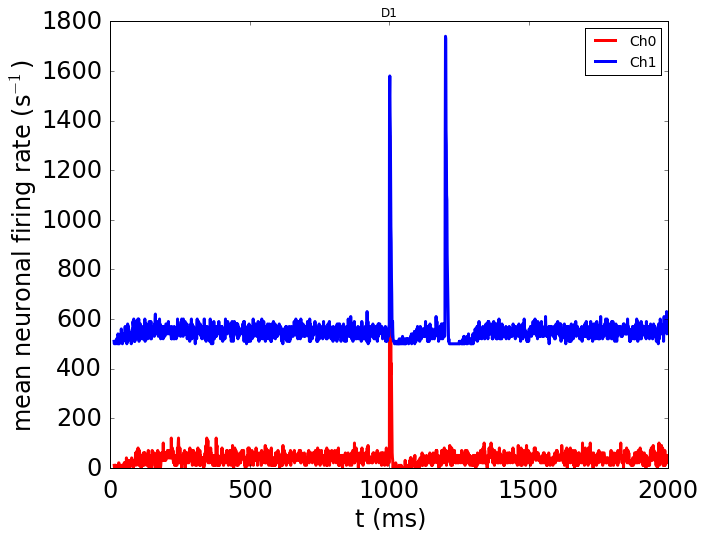

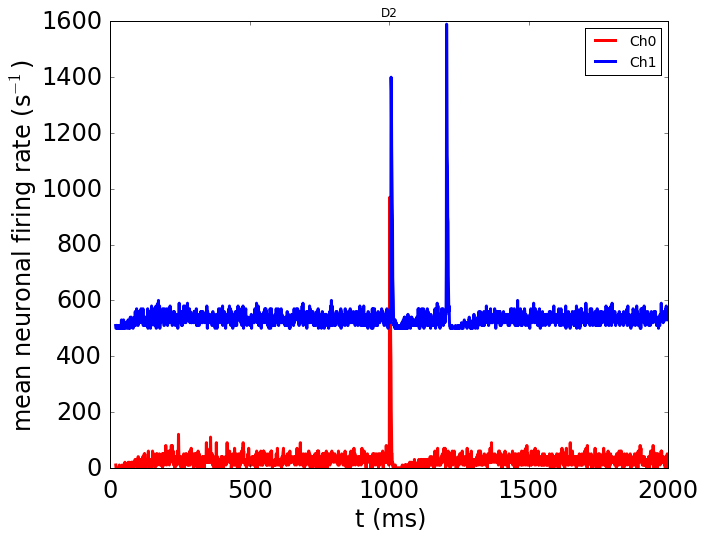

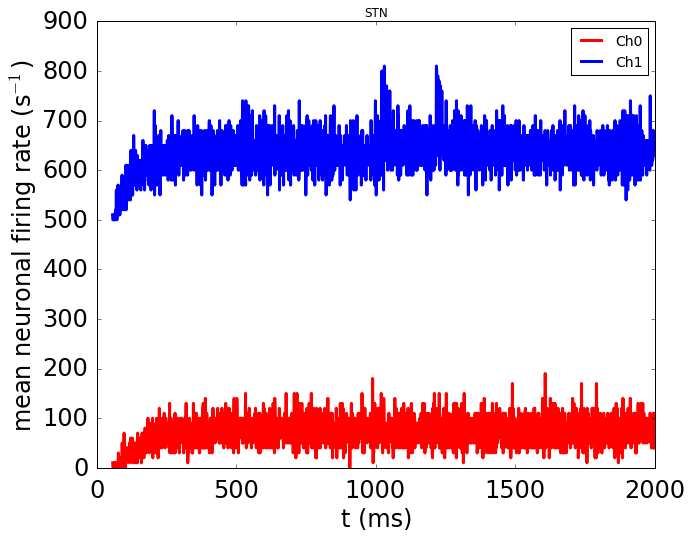

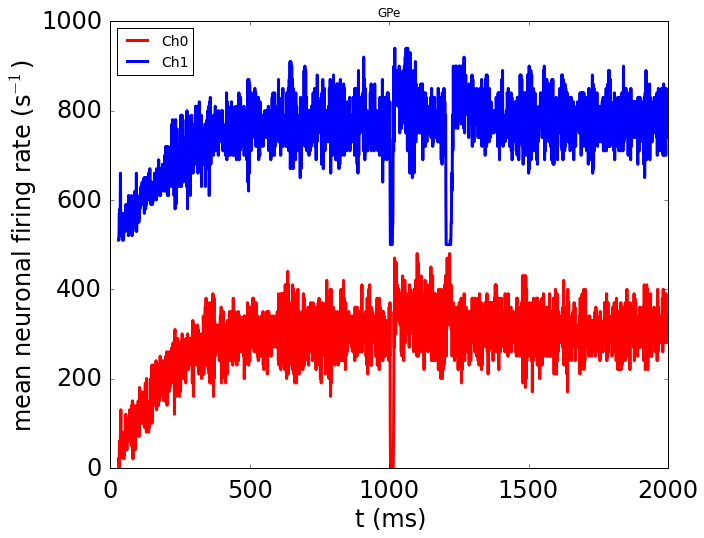

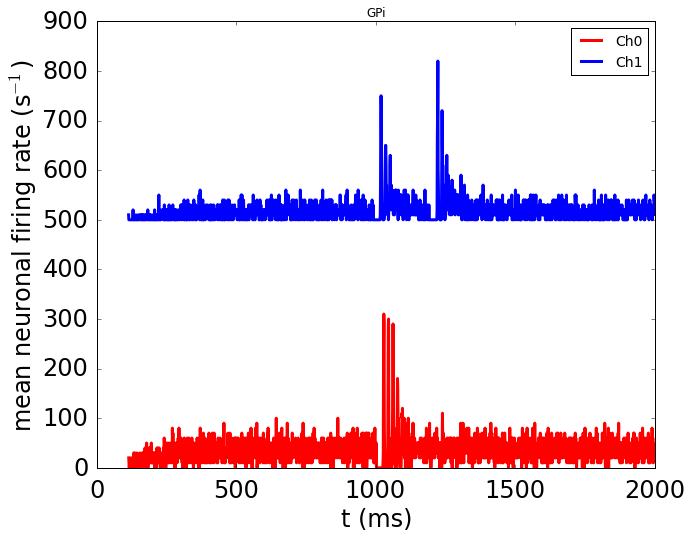

In [5]:
# Where is the data going to end up?
logdir1 = '/home/seb/tmp/impulse'

# Import update_bg1_model_xml.py
##import sys
##sys.path.append("../analysis")
#import update_bg1_model_xml as bg1update

print ('Response of BG1TC model to impulse input.')

# Where's the source model?
modeldir = '/home/seb/izhibg/GPR_Izhikevich/bg2'
expt = 3

import os
spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS'
spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
             'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -g -m '+modeldir+' -e'+\
             `expt` + ' -o ' + `logdir1` + ' ; popd"';

numrepeatruns = 100 # To match Tachibana et al 2008.

# Set to 0 if you're messing with the program and you already computed the simulation:
require_recompute = 0
load_data = 0

if require_recompute:
    sl_D1 = np.ndarray((0,2))
    sl_D2 = np.ndarray((0,2))
    sl_STN = np.ndarray((0,2))
    sl_GPe = np.ndarray((0,2))
    sl_GPi = np.ndarray((0,2))

    for i in range(0,numrepeatruns):
        os.system(spinemlcmd);

        # Build arrays for populations of interest
        logfile = '/log/D1_MSN_spike_log.csv'
        sl_D1_one = read_data (logdir1, logfile)
        sl_D1 = np.vstack((sl_D1, sl_D1_one))

        logfile = '/log/D2_MSN_spike_log.csv'
        sl_D2_one = read_data (logdir1, logfile)
        sl_D2 = np.vstack((sl_D2, sl_D2_one))
        
        logfile = '/log/STN_spike_log.csv'
        sl_STN_one = read_data (logdir1, logfile)
        sl_STN = np.vstack((sl_STN, sl_STN_one))
        
        logfile = '/log/GPe_spike_log.csv'
        sl_GPe_one = read_data (logdir1, logfile)
        sl_GPe = np.vstack((sl_GPe, sl_GPe_one))
        
        logfile = '/log/GPi_spike_log.csv'
        sl_GPi_one = read_data (logdir1, logfile)
        sl_GPi = np.vstack((sl_GPi, sl_GPi_one))
        
    np.savetxt('sl_D1.csv',sl_D1, delimiter=',')
    np.savetxt('sl_D2.csv',sl_D2, delimiter=',')
    np.savetxt('sl_STN.csv',sl_STN, delimiter=',')
    np.savetxt('sl_GPe.csv',sl_GPe, delimiter=',')
    np.savetxt('sl_GPi.csv',sl_GPi, delimiter=',')
    
elif load_data:
    # load from text file
    sl_D1 = np.genfromtxt ('sl_D1.csv', delimiter=',')
    sl_D2 = np.genfromtxt ('sl_D2.csv', delimiter=',')
    sl_STN = np.genfromtxt ('sl_STN.csv', delimiter=',')
    sl_GPe = np.genfromtxt ('sl_GPe.csv', delimiter=',')
    sl_GPi = np.genfromtxt ('sl_GPi.csv', delimiter=',')

numbins = 2000 # 2000 bins for 2 seconds gives 1 ms per bin, as used by Tachibana et al 2008.

vis_much_data (sl_D1, numbins, numrepeatruns, 'D1')
vis_much_data (sl_D2, numbins, numrepeatruns, 'D2')
vis_much_data (sl_STN, numbins, numrepeatruns, 'STN')
vis_much_data (sl_GPe, numbins, numrepeatruns, 'GPe')
vis_much_data (sl_GPi, numbins, numrepeatruns, 'GPi')


** 2016-09-06 **

I've got a problem with this TC loop, which is that given stochastic connections within each of the three channels, I have each of the TC loop channels having different responses - that is channel 3 stabilises at 500 spikes/s, but ch2 is only about 280 and ch3 is less still. If I re-generate the connections from Thalamus to cortex or vice versa, then the ordering changes, so it's all about the luck of the draw - if a channel gets regenerated with a few more connections, then it may produce a higher firing rate. This is not what I want; I want the channels to produce similar rates for background input.

A possible solution is to have 3 separate cortex populations, and tweak the weights from thalamus to the individual populations so that the firing rates stabilise to a similar rate. Simpler would be to have 3 different backgrounds that compensate for the wiring.

I found one problem was that I had different weights in the 2 synapses for the spike input -> Cortex connections.

Once that was fixed, I was surprised to find that I had to turn one of the channels input spike rate down to 3 compared with 5 for the other two channels. This means that Ch1 rises slower than the other two, but reaches the same mean equilibrium value. Re-generating the connectivity can change which channel is strongest (with all inputs set to 5). So I think to use a TC loop like this, I will need some sort of adaptation to get the channels to run up to the same equilibrium firing for background operation.

I think I'll try to fix this by changing weights from Spikes to Cortex.

**2016-09-08**

Yesterday, I sorted out the correct procedure for determining the statistics of the response of the network. This is to run the system N times, recording the spikes from neuron i each time. These spikes are then combined to give a firing distribution. N should be around 100 to match Tachibana et al 2008. The bin width should be 1 ms. The firing patterns of Poisson distribution inputs needs to be randomly seeded for each run. This requires adding a "set the seed" feature to SpineCreator and to SpineML_2_BRAHMS.

The problem, of course, is compute time. This is a candidate for execution on Iceberg. First I need the new "set the seed" feature in SC/S2B. This is essential, because I am going to need to run an optimisation process based on the result of running the model these 100 times. On the upside, I can compare any neuron from the simulation; I can easily train on N neurons and verify on M.

**2016-09-09**

I'm thinking about what parameters I will fix in the model prior to parameter searching. I'll fix the synapse models and therefore keep the connection weights identical for NMDA and AMPA synapses where there are two synapses per connection. I'll not allow the GP synapse parameters to vary stochastically (though they ought to, see Gunay et al).

I do need to decide upon the ratio of NMDA to AMPA synapses for STN->GPe/i connections and for Cortex->STN connections.

See the Synapses sub-collection for papers.

NMDA receptor properties don't vary very much across BG regions, whereas AMPA receptors do. See Goetz et all "Functional properties of AMPA and NMDA...".

Fr example, from that paper: "The de-activation of AMPARs after 1 msec pulses of glutamate was twofold
faster in patches isolated from globus pallidus neurons than in those
from striatal principal neurons (average deactivation time constant Tau 1.1 vs 2.2 msec, 1 m M glutamate; Fig. 4A, Table 1)." For this reason, I set tau ampa to 1.1 ms instead of 6 ms in the model for STN->GPe/i connection synapses.

Must check on why the Tau ampa is 6 ms in the MSNs. That number comes from Moyer et al, though I can't find it in the paper yet. Ok, it's in a section called "Synaptic input generation". It uses values form Chapman et al. *Evidence for functionally distinct synaptic NMDA receptors in ventromedial versus dorsolateral striatum.* 2003; Galarreta and Hestrin  *Properties of GABAA receptors underlying inhibitory synaptic currents in neocortical pyramidal neurons.* 1997; Gotz et al. *Functional properties of AMPA and NMDA receptors expressed in identified types of basal ganglia neurons * 1997. From Gotz, we get Striatal cholinergic interneurons with a Tau of 3.6 ms, whereas "striatal principle neurons" have Tau = 11.5 ms. Not quite 6 ms. Found it. The source for Moyer et al is Wolf et al *NMDA/AMPA Ratio Impacts State Transitions and Entrainment to Oscillations in a Computational Model of the Nucleus Accumbens Medium Spiny Projection Neuron*. The relevant information is listed in Table 3. THAT paper gets the numbers from Gotz  et  al., * Functional
properties of AMPA and NMDA receptors ...* 1997 and Chapman et al., *Evidence for functionally distinct synaptic NMDA receptors in ventromedial versus dorsolateral striatum.* 2003 [NMDA receptors only]. ***Goetz et al really is my source for AMPA and NMDA receptor time constants.***

So, in Goetz et al., reference is made to "deactivation tau" and "desensitisation tau". desensitization is the process by which for the same amount of neurotransmitter, the effect reduces; deactivation refers to the way that the neurotransmitter will be removed from the synaptic cleft. Wolf, Moyer, et al seem to have taken a mean of these two timescales as they are published in Goetz et al. For AMPA receptors they have $\tau_{on}$=1.1 ms and $\tau_{off}$=5.75 ms which they infer from the data in Goetz which says that for Striatum, the deactivation $\tau$ and the desensitisation $\tau$ are about 2.2 ms and about 11.5 ms, respectively. From this Wolf get $\tau_{off}$=5.75 ms, but without a clear indication of how. I'll see if Kevin knows - I need to understand it so that I can determine a time constant for the GP $\tau_{AMPA}$ from $\tau_{deact}$=1.1 ms and $\tau_{desens}$=5.1 ms and a time constant for STN from $\tau_{deact}$=1.6 ms and $\tau_{desens}$=3.6 ms. For now, I'll take the mean of each, so $\tau_{AMPA}^{GP}$=3.1 ms and $\tau_{AMPA}^{STN}$=2.6 ms, but I don't like this...

GABA time constants in Wolf et al. come from Galarreta M, Hestrin S (1997) *Properties of GABA A receptors underlying
inhibitory synaptic currents in neocortical pyramidal neurons*. 4 ms seems like a reasonable number for all the GABA receptors in the bg2 model.